In [2]:
import pandas as pd
import numpy as np

from scipy.stats import norm
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sns
sns.set()

## Import Dataset

In [27]:
# POC DATA - tGAN 400 rows
real_data = pd.read_csv('real_ctdata.csv')
syn_data = pd.read_csv('tgan_synthetic_400.csv')

In [54]:
# POC DATA ctGAN 382 rows
real_data = pd.read_csv('real_ctdata.csv')
syn_data = pd.read_csv('ctgan_synthetic_382.csv')

In [70]:
# Use case 1: Length of Stay tgan
real_data = pd.read_csv('los_use.csv')
syn_data = pd.read_csv('los_train_tgan.csv')

In [82]:
# Use case 1: Length of Stay ctgan
real_data = pd.read_csv('los_use.csv')
syn_data = pd.read_csv('los_use_ctgan_synthetic.csv')

In [507]:
# Use case 2: Mortality tgan
real_data = pd.read_csv('mortality_train.csv')
syn_data = pd.read_csv('mortality_train_tgan.csv')

In [87]:
# Use case 2: Mortality ctgan
real_data = pd.read_csv('mortality_train.csv')
syn_data = pd.read_csv('mortality_train_ctgan.csv')

In [73]:
real_data = real_data.loc[:, ~real_data.columns.str.contains('^Unnamed')]
syn_data = syn_data.loc[:, ~syn_data.columns.str.contains('^Unnamed')]

# Identify data types (if applicable)

### Option 1: when categorical and numerical columns are known

In [ ]:
cat_list = []
num_list = []
real_cat = real_data[cat_list]
real_num = real_data[num_list]
syn_cat = syn_data[cat_list]
syn_num = syn_data[num_list]

### Option 2: when categorical and numerical columns are unknown

In [521]:
##Separate dataset by data types

# get id columns
real_id = real_data.loc[:, real_data.columns.str.contains('id|ID')]
# get time series columns
real_ts = real_data.loc[:, real_data.columns.str.contains("time|dob|dod")]
# get numerical columns
real_num = real_data._get_numeric_data()
real_bi = real_num.loc[:, real_num.columns.str.contains('has|flag|FLAG')]
real_num = real_num.loc[:, ~real_num.columns.str.contains('id|ID|time|has|flag|FLAG')]
# get categorical columns
real_cat = real_data.select_dtypes('object')
real_cat = real_cat.loc[:, ~real_cat.columns.str.contains("time|dob|dod")]
real_cat = pd.concat([real_cat, real_bi], axis=1, sort=False)
real_cat = pd.concat([real_cat, real_id], axis=1, sort=False)

##Separate synthetic dataset by data types
# get id columns
syn_id = syn_data.loc[:, syn_data.columns.str.contains('id|ID')]
# get time series columns
syn_ts = syn_data.loc[:, syn_data.columns.str.contains("time|dob|dod")]
# get numerical columns
syn_num = syn_data._get_numeric_data()
syn_bi = syn_num.loc[:, syn_num.columns.str.contains('has|flag|FLAG')]
syn_num = syn_num.loc[:, ~syn_num.columns.str.contains('id|ID|time|has|flag|FLAG')]
# get categorical columns
syn_cat = syn_data.select_dtypes('object')
syn_cat = syn_cat.loc[:, ~syn_cat.columns.str.contains("time|dob|dod")]
syn_cat = pd.concat([syn_cat, syn_bi], axis=1, sort=False)
syn_cat = pd.concat([syn_cat, syn_id], axis=1, sort=False)

In [522]:
# To identify categorical columns that are in numerical format in the dataset, I created a function to identify the likely categorical columns based on the proportion of the unique values in a variable
def identify_cat(df):
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold
    cat_cols = []
    for k,v in likely_cat.items():
        if v == True:
            cat_cols.append(k)
    return cat_cols

real_numcat = real_num[identify_cat(real_num)]
real_cat = pd.concat([real_cat, real_numcat], axis=1, sort=False)
real_num.drop(columns = real_numcat, inplace = True)
syn_numcat = syn_num[identify_cat(syn_num)]
syn_cat = pd.concat([syn_cat, syn_numcat], axis=1, sort=False)
syn_num.drop(columns = syn_numcat, inplace = True)

## Probability Distribution (KL-divergence)

The lower the KL divergence, the closer the two distributions are to one another.

In [523]:
# p and q have to be probability distributions, which means they should be sum of 1.
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

from scipy.spatial import distance
def cos_similarity(p,q):
    return 1 - distance.cosine(p, q)

## 1) Discrete Data

In [106]:
# categorical data
def discret_probs(column):
    counts = column.value_counts()
    freqs ={counts.index[i]: counts.values[i] for i in range(len(counts.index))} 
    probs = []
    for k,v in freqs.items():
        probs.append(v/len(column))
    return np.array(probs)


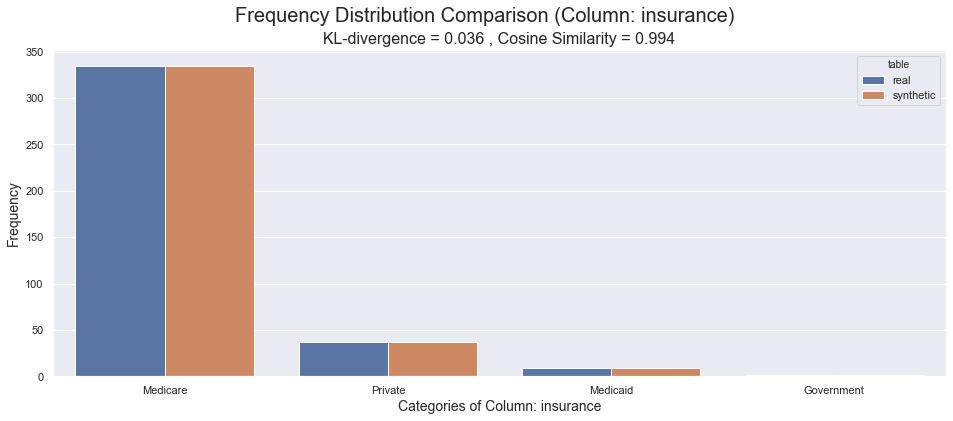

In [61]:
#### categorical column 
def cat_plot(colname, realdata, syndata):
    real_p = discret_probs(realdata[colname])
    syn_p = discret_probs(syndata[colname])
    real_plt = pd.DataFrame({colname:realdata[colname], 'table': 'real'})
    syn_plt = pd.DataFrame({colname:realdata[colname], 'table': 'synthetic'})
    df_plt = pd.concat([real_plt, syn_plt], axis=0, sort=False)
    kl = kl_divergence(np.array(real_p), np.array(syn_p))
    cos_sim = cos_similarity(real_p,syn_p)

    plt.figure(figsize = [16, 6])
    plt.title('KL-divergence = %1.3f , Cosine Similarity = %1.3f'% (kl, cos_sim), fontsize = 16)
    sns.countplot(x=colname, hue="table", data=df_plt)
    plt.suptitle('Frequency Distribution Comparison (Column: {})'.format(colname), fontsize = 20)
    plt.xlabel('Categories of Column: {}'.format(colname),fontsize = 14)
    plt.ylabel("Frequency",fontsize = 14)
    
cat_plot('insurance', real_data, syn_data)

## 2) Continuous data

### 2.1 Convert with rounded numbers (Use case 1)

In [524]:

# Replace missing values in 'Length of Stay' with 0
real_num['LOS'].fillna(0, inplace = True)
syn_num['LOS'].fillna(0, inplace = True)
real_num['LOS'] = real_num['LOS'].apply(round)
syn_num['LOS'] = syn_num['LOS'].apply(round)
max_numlen = max(max(real_num['LOS']), max(syn_num['LOS']))
min_numlen = min(min(real_num['LOS']), min(syn_num['LOS']))

def continuous_probs(table,column):
    counts = table[column].value_counts()
    freqs = {counts.index[i]: counts.values[i] for i in range(len(counts.index))}
    for i in range(min(freqs.keys()), max(freqs.keys())+1):
        if i not in freqs.keys():
            freqs[i] = 0
    for j in range(max(freqs.keys()), max_numlen + 1):
        if j not in freqs.keys():
            freqs[j] = 0
    for j in range(min_numlen, max(freqs.keys()) +1):
        if j not in freqs.keys():
            freqs[j] = 0
    sorted_freqs = {}
    for k in sorted(freqs.keys()):
        sorted_freqs[k] = freqs[k]
    probs = []
    for k,v in sorted_freqs.items():
        probs.append(v/len(table[column]))
    return sorted_freqs, np.array(probs)

def plot_axis(colname, realdata, syndata):
    real_freqs = continuous_probs(realdata,colname)[0]
    syn_freqs = continuous_probs(syndata,colname)[0]
    keys = list(real_freqs.keys())
    real_vals = list(real_freqs.values())
    syn_vals = list(syn_freqs.values())    
    x_min = min(keys)
    x_max = max(keys)
    y_min = min(min(real_vals), min(syn_vals)) +1
    y_max = max(max(real_vals), max(syn_vals)) +1
    return [x_min, x_max, y_min, y_max]



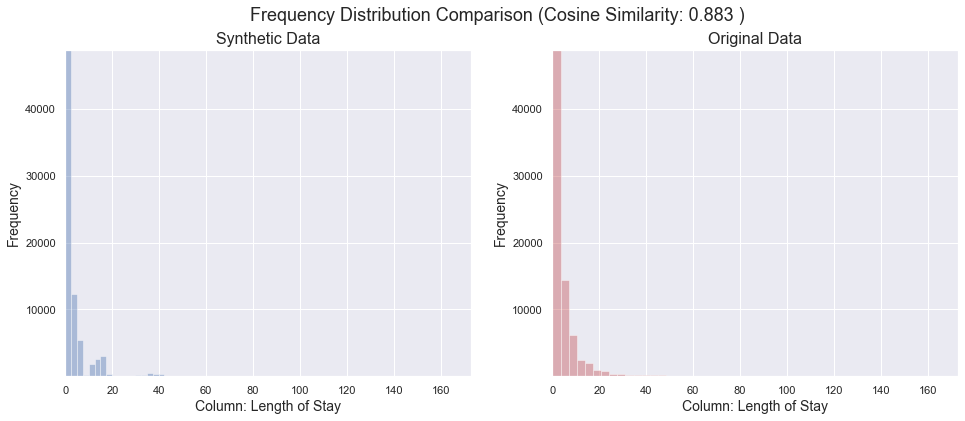

In [528]:
def num_plot(colname, realdata, syndata):
    real_p = continuous_probs(realdata,colname)[1]
    syn_p = continuous_probs(syndata,colname)[1]
    cos_sim = cos_similarity(real_p,syn_p)
    plt.figure(figsize = [16, 6])
    plt.suptitle('Frequency Distribution Comparison (Cosine Similarity: %1.3f )'%  cos_sim, fontsize = 18)
    plt.subplot(121)
    plt.title('Synthetic Data', fontsize = 16)
    sns.distplot(syndata[colname], color = 'b', kde = False)
    plt.xlabel('Column: Length of Stay',fontsize = 14)
    plt.ylabel("Frequency",fontsize = 14)
    plt.axis(plot_axis(colname, realdata, syndata))
    plt.subplot(122)
    plt.title('Original Data', fontsize = 16)
    sns.distplot(realdata[colname], color = 'r', kde = False)
    plt.xlabel('Column: Length of Stay' ,fontsize = 14)
    plt.ylabel("Frequency",fontsize = 14)
    plt.axis(plot_axis(colname, realdata, syndata))
    plt.show()
        
num_plot('LOS', real_num, syn_num)

### 2.2 Convert with bins (Use case 2)

In [74]:
max_numlen = max(max(real_data['NUMLABEVENTS']), max(syn_data['NUMLABEVENTS']))
min_numlen = min(min(real_data['NUMLABEVENTS']), min(syn_data['NUMLABEVENTS']))
print('max: ',max_numlen)
print('min: ',min_numlen)

max:  13713.0
min:  -26.72729965


In [75]:
### Decide the bins by yourself:
# The upper bound should be 2 more steps more than the maximum value of both vectors
# Controling the whole length of the bins to around 200 woyld be optimal 

bins = np.arange(-50,13800,10)

real_inds = pd.DataFrame(np.digitize(real_data['NUMLABEVENTS'], bins), columns = ['inds'])
syn_inds = pd.DataFrame(np.digitize(syn_data['NUMLABEVENTS'], bins), columns = ['inds'])



In [515]:
len(bins)

1385

In [76]:
from scipy.spatial import distance

def identify_probs(table,column):
    counts = table[column].value_counts()
    freqs = {counts.index[i]: counts.values[i] for i in range(len(counts.index))}
    for i in range(1, len(bins)+1):
        if i not in freqs.keys():
            freqs[i] = 0
    sorted_freqs = {}
    for k in sorted(freqs.keys()):
        sorted_freqs[k] = freqs[k]
    probs = []
    for k,v in sorted_freqs.items():
        probs.append(v/len(table[column]))
    return sorted_freqs, np.array(probs)


real_p = identify_probs(real_inds,'inds')[1]
syn_p = identify_probs(syn_inds,'inds')[1]

def cos_similarity(p,q):
    return 1 - distance.cosine(p, q)

cos_sim = cos_similarity(real_p,syn_p)

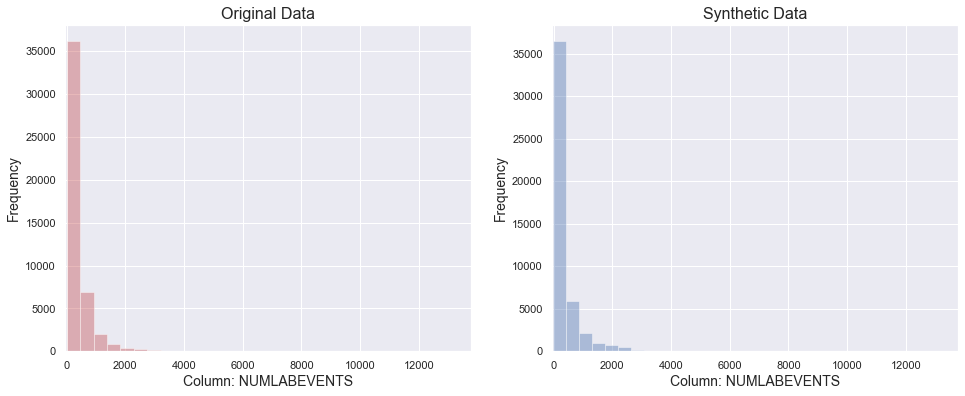

In [79]:
def num_plot(colname, realdata, syndata):
    plt.figure(figsize = [16, 6])
    plt.suptitle('Frequency Distribution Comparison (Cosine Similarity: %1.3f )'%  cos_sim, fontsize = 18)
    plt.subplot(121)    
    plt.title('Original Data', fontsize = 16)
    sns.distplot(realdata[colname], bins = 30,color = 'r', kde = False)
    plt.xlabel('Column: {}'.format(colname) ,fontsize = 14)
    plt.ylabel("Frequency",fontsize = 14)
    plt.xlim(min(bins), max(bins))
    plt.subplot(122)
    plt.title('Synthetic Data', fontsize = 16)
    sns.distplot(syndata[colname], bins = 10, color = 'b', kde = False)
    plt.xlabel('Column: {}'.format(colname),fontsize = 14)
    plt.ylabel("Frequency",fontsize = 14)
    plt.xlim(min(bins), max(bins))
    
    plt.show()
        
num_plot('NUMLABEVENTS', real_data, syn_data)

## 3) Time Series Data

In [37]:
real_ts.head()

""
0
1
2
3
4


## 4) ID Data

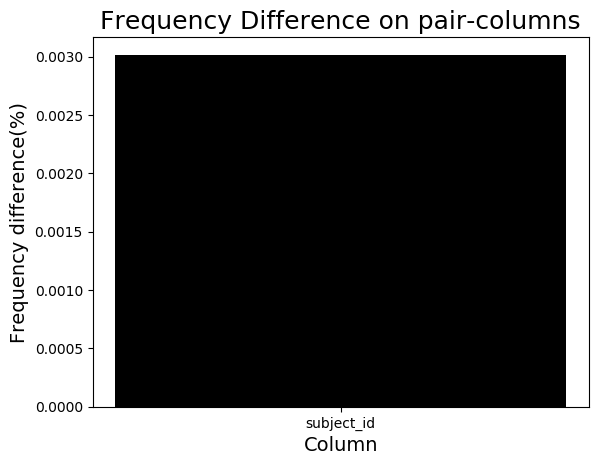

In [39]:
# Evaluate by frequency
def plot_id_freq_diff(real_cat, syn_cat):
    result = []
    for col in real_cat.columns:
        freq_real = pd.DataFrame(real_cat[col].value_counts()/len(real_cat.index))
        freq_syn = pd.DataFrame(syn_cat[col].value_counts()/len(syn_cat.index))
        freq_df = pd.concat([freq_real, freq_syn], axis=1, sort=False)
        freq_df['diff'] = abs(freq_df.iloc[:,0] - freq_df.iloc[:,1])
        result.append(freq_df['diff'].mean())

    
    y_co = result
    x_co = real_cat.columns
    plt.bar(x_co,y_co, width = 0.5, color = 'black')
    plt.title('Frequency Difference on pair-columns',fontsize=18)
    plt.xlabel('Column',fontsize=14)
    plt.ylabel('Frequency difference(%)',fontsize=14)
    return plt.show() 
    

plot_id_freq_diff(real_id, syn_id)